## PART 0 - IMPORT TRAINED MODEL

In [1]:
#from tensorflow.keras.models import load_model

#regressor_model = load_model('trained_model.keras')

## PART 1 - DATA PREPROCESSING

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, Input, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Import the training set

In [3]:
ds_train = yf.download('^GSPC', start='2010-01-01', end='2025-01-01', auto_adjust = True)
df_train = pd.DataFrame(ds_train)

df_train

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000
...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000


### Column selection

In [4]:
df_closing_prices = df_train[['Close']]

df_closing_prices

Price,Close
Ticker,^GSPC
Date,
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980
...,...
2024-12-24,6040.040039
2024-12-26,6037.589844


### Scaling data

In [5]:
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(df_closing_prices)

training_set_scaled, training_set_scaled.shape

(array([[0.02178704],
        [0.02248362],
        [0.02260596],
        ...,
        [0.97643301],
        [0.96382374],
        [0.95882934]]),
 (3774, 1))

### Training sequences

In [6]:
def create_dataset(data, time_step):
    X_total, y_total = [], []
    
    for i in range(time_step, len(data)):
        X_total.append(data[i-time_step:i, 0])  # Los últimos 60 días
        y_total.append(data[i, 0])  # El precio de cierre del día siguiente
    
    return np.array(X_total), np.array(y_total)

In [7]:
X_total, y_total = create_dataset(training_set_scaled, 60)

In [8]:
pd.DataFrame(X_total)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.021787,0.022484,0.022606,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,...,0.028342,0.028267,0.027097,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735
1,0.022484,0.022606,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,...,0.028267,0.027097,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978
2,0.022606,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,0.022784,...,0.027097,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978,0.030689
3,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,0.022784,0.018529,...,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978,0.030689,0.032532
4,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,0.022784,0.018529,0.013651,...,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978,0.030689,0.032532,0.032926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,0.935318,0.924715,0.924871,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,...,0.989076,0.998800,0.992300,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070
3710,0.924715,0.924871,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,0.954532,...,0.998800,0.992300,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070,0.990088
3711,0.924871,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,0.954532,0.945733,...,0.992300,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070,0.990088,0.989605
3712,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,0.954532,0.945733,0.951102,...,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070,0.990088,0.989605,0.976433


In [9]:
pd.DataFrame(y_total)

,0
0,0.028978
1,0.030689
2,0.032532
3,0.032926
4,0.031547
...,...
3709,0.990088
3710,0.989605
3711,0.976433
3712,0.963824


### Split into training set and testing set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.1, shuffle=False)

In [11]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.021787,0.022484,0.022606,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,...,0.028342,0.028267,0.027097,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735
1,0.022484,0.022606,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,...,0.028267,0.027097,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978
2,0.022606,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,0.022784,...,0.027097,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978,0.030689
3,0.023504,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,0.022784,0.018529,...,0.028263,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978,0.030689,0.032532
4,0.024153,0.024548,0.022424,0.024291,0.024840,0.022387,0.025189,0.022784,0.018529,0.013651,...,0.029913,0.028640,0.028248,0.028417,0.029726,0.029735,0.028978,0.030689,0.032532,0.032926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,0.608253,0.609061,0.609027,0.605674,0.616383,0.614690,0.617390,0.618090,0.618021,0.613141,...,0.664234,0.659691,0.662888,0.656265,0.652416,0.662201,0.661895,0.665759,0.676403,0.677431
3338,0.609061,0.609027,0.605674,0.616383,0.614690,0.617390,0.618090,0.618021,0.613141,0.613877,...,0.659691,0.662888,0.656265,0.652416,0.662201,0.661895,0.665759,0.676403,0.677431,0.675700
3339,0.609027,0.605674,0.616383,0.614690,0.617390,0.618090,0.618021,0.613141,0.613877,0.614572,...,0.662888,0.656265,0.652416,0.662201,0.661895,0.665759,0.676403,0.677431,0.675700,0.668748
3340,0.605674,0.616383,0.614690,0.617390,0.618090,0.618021,0.613141,0.613877,0.614572,0.601665,...,0.656265,0.652416,0.662201,0.661895,0.665759,0.676403,0.677431,0.675700,0.668748,0.666254


In [12]:
pd.DataFrame(y_train)

,0
0,0.028978
1,0.030689
2,0.032532
3,0.032926
4,0.031547
...,...
3337,0.675700
3338,0.668748
3339,0.666254
3340,0.668342


In [13]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.614690,0.617390,0.618090,0.618021,0.613141,0.613877,0.614572,0.601665,0.598578,0.614238,...,0.662201,0.661895,0.665759,0.676403,0.677431,0.675700,0.668748,0.666254,0.668342,0.674209
1,0.617390,0.618090,0.618021,0.613141,0.613877,0.614572,0.601665,0.598578,0.614238,0.620973,...,0.661895,0.665759,0.676403,0.677431,0.675700,0.668748,0.666254,0.668342,0.674209,0.680701
2,0.618090,0.618021,0.613141,0.613877,0.614572,0.601665,0.598578,0.614238,0.620973,0.620656,...,0.665759,0.676403,0.677431,0.675700,0.668748,0.666254,0.668342,0.674209,0.680701,0.688175
3,0.618021,0.613141,0.613877,0.614572,0.601665,0.598578,0.614238,0.620973,0.620656,0.611127,...,0.676403,0.677431,0.675700,0.668748,0.666254,0.668342,0.674209,0.680701,0.688175,0.687264
4,0.613141,0.613877,0.614572,0.601665,0.598578,0.614238,0.620973,0.620656,0.611127,0.605438,...,0.677431,0.675700,0.668748,0.666254,0.668342,0.674209,0.680701,0.688175,0.687264,0.690691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,0.935318,0.924715,0.924871,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,...,0.989076,0.998800,0.992300,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070
368,0.924715,0.924871,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,0.954532,...,0.998800,0.992300,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070,0.990088
369,0.924871,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,0.954532,0.945733,...,0.992300,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070,0.990088,0.989605
370,0.922977,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,0.954532,0.945733,0.951102,...,0.992269,0.996805,0.992174,0.956961,0.955958,0.968542,0.977070,0.990088,0.989605,0.976433


In [14]:
pd.DataFrame(y_test)

,0
0,0.680701
1,0.688175
2,0.687264
3,0.690691
4,0.697043
...,...
367,0.990088
368,0.989605
369,0.976433
370,0.963824


### Reshaping for 3D

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train, X_train.shape

(array([[[0.02178704],
         [0.02248362],
         [0.02260596],
         ...,
         [0.02841728],
         [0.02972557],
         [0.02973544]],
 
        [[0.02248362],
         [0.02260596],
         [0.02350379],
         ...,
         [0.02972557],
         [0.02973544],
         [0.02897771]],
 
        [[0.02260596],
         [0.02350379],
         [0.02415301],
         ...,
         [0.02973544],
         [0.02897771],
         [0.03068853]],
 
        ...,
 
        [[0.60902698],
         [0.60567437],
         [0.61638344],
         ...,
         [0.67743091],
         [0.67570033],
         [0.66874845]],
 
        [[0.60567437],
         [0.61638344],
         [0.61469035],
         ...,
         [0.67570033],
         [0.66874845],
         [0.66625428]],
 
        [[0.61638344],
         [0.61469035],
         [0.61738974],
         ...,
         [0.66874845],
         [0.66625428],
         [0.66834194]]]),
 (3342, 60, 1))

## PART 2 - BUILDING AND TRAINING THE RNN

### Initialising the RNN

In [16]:
regressor_model = Sequential()

### Adding the input layer

In [17]:
regressor_model.add(Input(shape = (X_train.shape[1], 1)))

### Adding the first hidden LSTM layer

In [18]:
regressor_model.add(LSTM(units = 50, return_sequences = True))
regressor_model.add(Dropout(0.2))

### Adding the last hidden LSTM layer

In [19]:
regressor_model.add(LSTM(units = 50))
regressor_model.add(Dropout(0.2))

### Adding the output layer

In [20]:
regressor_model.add(Dense(units = 1))

### Compiling the RNN

In [21]:
regressor_model.compile(optimizer = "adam", loss = "mean_squared_error", metrics=["mae", "mse"])

### Model summary

In [22]:
regressor_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting the RNN to the training set

In [23]:
history = regressor_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0242 - mae: 0.0921 - mse: 0.0242 - val_loss: 3.4273e-04 - val_mae: 0.0139 - val_mse: 3.4273e-04
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0015 - mae: 0.0261 - mse: 0.0015 - val_loss: 0.0010 - val_mae: 0.0283 - val_mse: 0.0010
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0011 - mae: 0.0219 - mse: 0.0011 - val_loss: 0.0014 - val_mae: 0.0341 - val_mse: 0.0014
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011 - mae: 0.0218 - mse: 0.0011 - val_loss: 5.3570e-04 - val_mae: 0.0199 - val_mse: 5.3570e-04
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0011 - mae: 0.0219 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0293 - val_mse: 0.0011
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.3531e-04 - mae: 0.0206 - mse: 9.3531e-04 - val_loss: 0.0026 - val_mae: 0.0470 - val_mse: 0.0026
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.

In [24]:
regressor_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

## PART 3 - MAKING THE PREDICTIONS AND VISUALISING THE RESULTS

### Calculating prediction and transform the results into 2D arrays

In [25]:
# Calcular las predicciones
predicted_stock_price = regressor_model.predict(X_test)

pd.DataFrame(predicted_stock_price)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 


,0
0,0.659035
1,0.664106
2,0.670631
3,0.674312
4,0.676660
...,...
367,0.935371
368,0.946233
369,0.951557
370,0.946526


In [26]:
# Invertir la normalización para obtener los precios en su escala original
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

print(predicted_stock_price.shape, real_stock_price.shape)

(372, 1) (372, 1)


### Preparing the results

In [27]:
dates = pd.date_range(start=df_closing_prices.index[-372], periods=372, freq='B')

dates

DatetimeIndex(['2023-07-12', '2023-07-13', '2023-07-14', '2023-07-17',
               '2023-07-18', '2023-07-19', '2023-07-20', '2023-07-21',
               '2023-07-24', '2023-07-25',
               ...
               '2024-11-29', '2024-12-02', '2024-12-03', '2024-12-04',
               '2024-12-05', '2024-12-06', '2024-12-09', '2024-12-10',
               '2024-12-11', '2024-12-12'],
              dtype='datetime64[ns]', length=372, freq='B')

In [28]:
df_results = pd.DataFrame({
    'Date': dates,
    'Real': real_stock_price.flatten(),
    'Predicted': predicted_stock_price.flatten()
})

df_results

,Date,Real,Predicted
0,2023-07-12,4472.160156,4362.364258
1,2023-07-13,4510.040039,4388.063965
2,2023-07-14,4505.419922,4421.128906
3,2023-07-17,4522.790039,4439.782227
4,2023-07-18,4554.979980,4451.684570
...,...,...,...
367,2024-12-06,6040.040039,5762.751953
368,2024-12-09,6037.589844,5817.797363
369,2024-12-10,5970.839844,5844.777832
370,2024-12-11,5906.939941,5819.282227


### Visualising the results

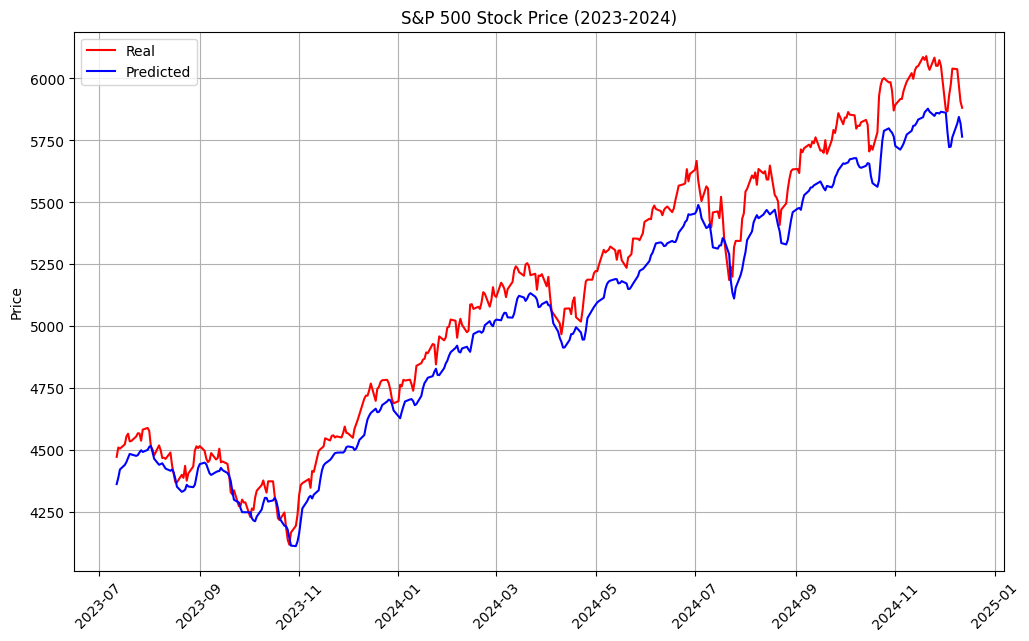

In [29]:
plt.figure(figsize=(12, 7))

plt.plot(df_results['Date'], df_results['Real'], color='red', label='Real')
plt.plot(df_results['Date'], df_results['Predicted'], color='blue', label='Predicted')

plt.title('S&P 500 Stock Price (2023-2024)')

plt.ylabel('Price')
plt.xticks(rotation = 45)

plt.legend()
plt.grid(True)

plt.show()

## PART 4 - EVALUATING THE RNN

### LOSS -> MSE (Mean Squared Error)

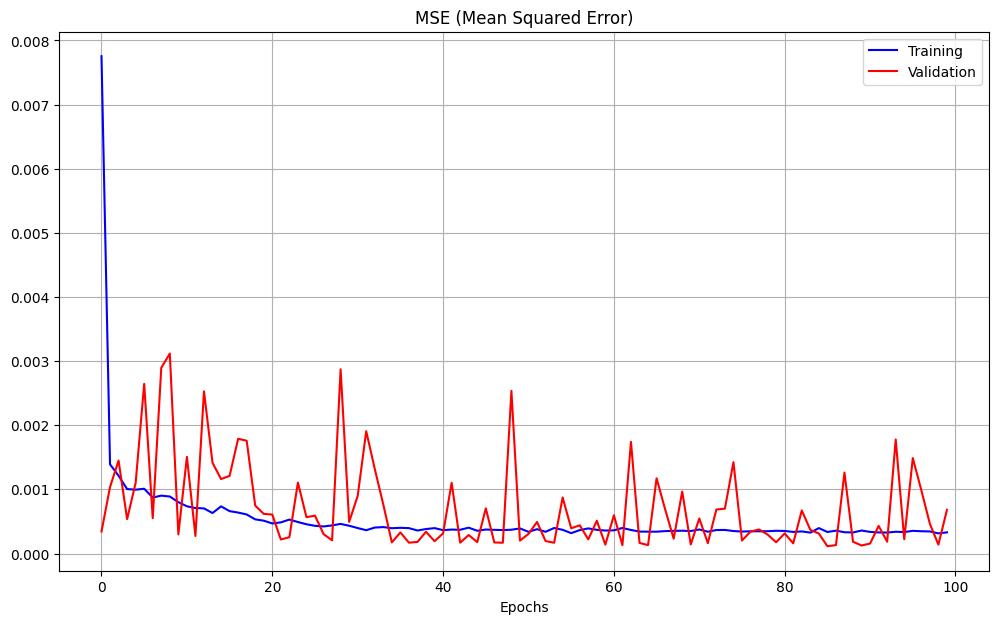

In [30]:
plt.figure(figsize=(12, 7))

plt.plot(history.history['mse'], color='blue', label='Training')
plt.plot(history.history['val_mse'], color='red', label='Validation')

plt.title('MSE (Mean Squared Error)')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.show()

### MAE (Mean Absolute Error)

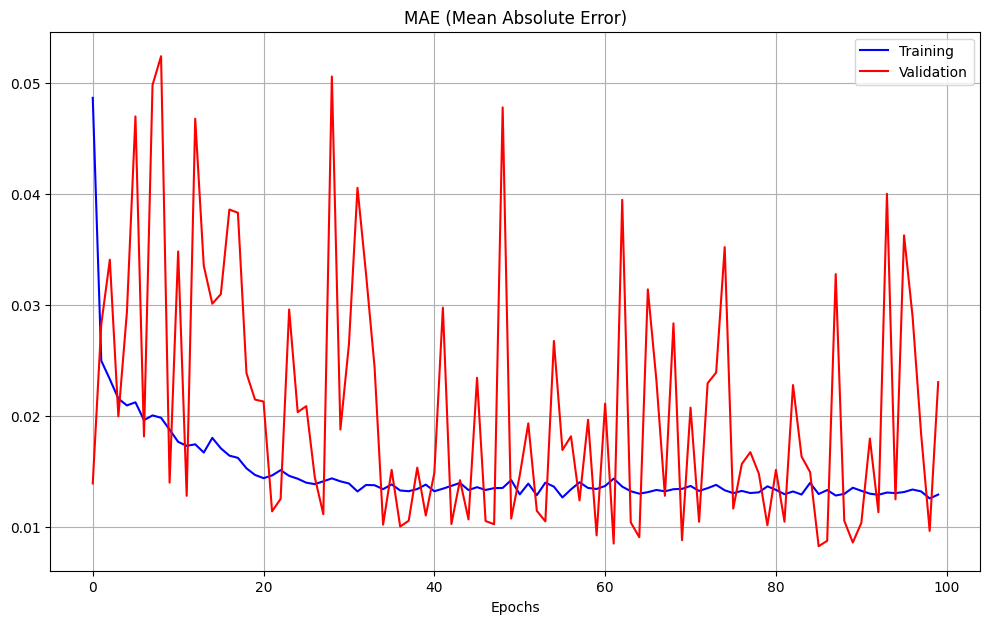

In [31]:
plt.figure(figsize=(12, 7))

plt.plot(history.history['mae'], color='blue', label='Training')
plt.plot(history.history['val_mae'], color='red', label='Validation')

plt.title('MAE (Mean Absolute Error)')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.show()

In [32]:
test_loss, test_mae, test_mse = regressor_model.evaluate(X_test, y_test)

print("MAE:", test_mae)
print("MSE:", test_mse)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9937e-04 - mae: 0.0171 - mse: 3.9937e-04 
MAE: 0.0230358075350523
MSE: 0.000680987723171711


### RMSE (Root Mean Squared Error)

In [33]:
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

print("RMSE:", rmse)

RMSE: 132.24510396511454


### Relative RMSE

In [34]:
price_range = max(real_stock_price) - min(real_stock_price)
relative_rmse = rmse / price_range

print("Relative RMSE:", relative_rmse)

Relative RMSE: [0.06703082]


## PART 5 - EXPORT TRAINED MODEL AND SCALER

In [35]:
regressor_model.save("trained_model.keras")

In [36]:
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## PART 6 - CALCULATING NEW HORIZON TIME

### Last 60-day sequence (escalation)

In [37]:
last_days = training_set_scaled[-61:].astype(np.float32)

pd.DataFrame(last_days)

,0
0,0.933066
1,0.922187
2,0.933078
3,0.941151
4,0.938785
...,...
56,0.990088
57,0.989605
58,0.976433
59,0.963824


In [38]:
X_test_january, y_test_january = create_dataset(last_days, 60)

pd.DataFrame(X_test_january)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.933066,0.922187,0.933078,0.941151,0.938785,0.945687,0.954532,0.945733,0.951102,0.950905,...,0.996805,0.992174,0.956961,0.955958,0.968542,0.97707,0.990088,0.989605,0.976433,0.963824


In [39]:
pd.DataFrame(y_test_january)

,0
0,0.958829


### Recursive calculations January 2025

In [40]:
# Copy of the last 60 values of X_test
X_test_january = training_set_scaled[-60:].flatten()

# List for storing future predictions
january_2025_prediction = []

# Difference between the last actual value and the previous one (to adjust trend correctly)
real_trend = training_set_scaled[-1] - training_set_scaled[-2]

for _ in range(7):  # 20 financial days ~ 1 normal month
    # Convert sequence to TensorFlow tensor
    sequence_for_pred_tensor = tf.convert_to_tensor(X_test_january.reshape(1, 60, 1), dtype=tf.float32)

    # Predict the following value
    next_day_prediction = regressor_model(sequence_for_pred_tensor, training=False).numpy().flatten()[0]

    # Compare the last prediction with the last actual value
    last_real_value = training_set_scaled[-1]  # Last actual value available
    last_predicted_value = january_2025_prediction[-1] if january_2025_prediction else last_real_value

    # Trend adjustment with actual comparison
    trend_adjustment = (last_real_value - last_predicted_value) * 0.5  # Corrects the deviation at each iteration
    next_day_prediction += np.random.normal(0, 0.005) + trend_adjustment

    # Save the prediction
    january_2025_prediction.append(next_day_prediction)

    # Update the sequence for the next iteration
    X_test_january = np.append(X_test_january[1:], next_day_prediction)

# Transform predictions to original scale
january_2025_prediction_original_scale = scaler.inverse_transform(np.array(january_2025_prediction).reshape(-1, 1))

In [41]:
january_2025_prediction_original_scale.shape

(7, 1)

### January 2025 actual

In [42]:
ds_january_2025_real = yf.download('^GSPC', start='2025-01-01', end='2025-01-14', auto_adjust = True)
df_january_2025_real = pd.DataFrame(ds_january_2025_real[['Close']])

df_january_2025_real.shape

[*********************100%***********************]  1 of 1 completed


(7, 1)

### Combining actual and predicted data

In [43]:
df_january_2025_combined = df_january_2025_real.copy()

df_january_2025_combined['Predicted'] = january_2025_prediction_original_scale

df_january_2025_combined.index.name = 'Date'
df_january_2025_combined.columns = ['Real', 'Predicted']

df_january_2025_combined

,Real,Predicted
Date,,
2025-01-02,5868.549805,5683.542495
2025-01-03,5942.470215,5722.414440
2025-01-06,5975.379883,5696.489573
2025-01-07,5909.029785,5706.698580
2025-01-08,5918.250000,5682.351452
2025-01-10,5827.040039,5653.618506
2025-01-13,5836.220215,5680.467070


### Actual vs. predictive chart

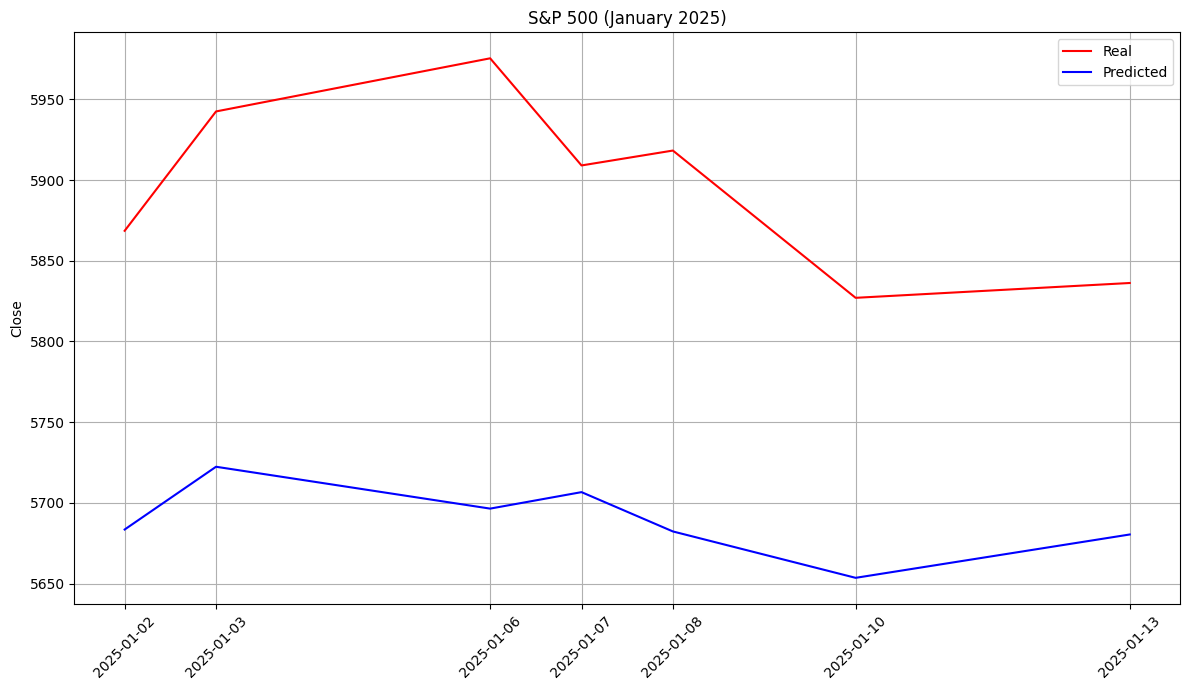

In [44]:
plt.figure(figsize=(12, 7))

plt.plot(df_january_2025_combined.index,
         df_january_2025_combined['Real'],
         color='red',
         label='Real')

plt.plot(df_january_2025_combined.index,
         df_january_2025_combined['Predicted'],
         color='blue',
         label='Predicted')

plt.title('S&P 500 (January 2025)')
plt.ylabel('Close')
plt.xticks(ticks=df_january_2025_combined.index,
           labels=df_january_2025_combined.index.strftime('%Y-%m-%d'),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### MAE

In [45]:
# Escalar los datos reales y predichos
y_real_scaled = scaler.fit_transform(df_january_2025_real)
y_pred_scaled = scaler.transform(january_2025_prediction_original_scale)

mae_scaled = mean_absolute_error(y_real_scaled, y_pred_scaled)
print(f"MAE normalizado: {mae_scaled:.4f}")

MAE normalizado: 1.3977


### RMSE

In [46]:
new_rmse = math.sqrt(mean_squared_error(df_january_2025_real, january_2025_prediction_original_scale))

print("RMSE:", new_rmse)

RMSE: 210.90016762231153


### Relative RMSE

In [47]:
new_price_range = df_january_2025_real.max().iloc[0] - df_january_2025_real.min().iloc[0]
new_relative_rmse = new_rmse / new_price_range

print("Relative RMSE:", new_relative_rmse)

Relative RMSE: 1.4217364821938578
